In [21]:
from pathlib import Path
import sys
pwd = str(Path("..").absolute())
sys.path.insert(0, pwd)

from Pyrser import pyrser
from Node import Node, FileNode, FncNode
from Utils.PyrserHelpers import xfs
import graphviz; from graphviz import Digraph

In [119]:
file = "/home/kemri/Projects/pyrser/test_files/test5.py"
output = pyrser(file)

In [120]:
output

FileNode(name='test5.py', scope=[1, 16], location=/home/kemri/Projects/pyrser/test_files/test5.py)
 |-- FncNode(name='fnc1', scope=[1, 3])
 |    |-- FncNode(name='inner', scope=[2, 3])
 |-- ClsNode(name='cls1', scope=[6, 8])
 |-- ClsNode(name='cls2', scope=[11, 12])
 |-- FncNode(name='fnc2', scope=[15, 16])

#### The rules
- if a node has children, create a subgraph with label=node_name
- for every node with a parent, add that node to the parent's subgraph

For test2.py, traversing the Node tree, it would mean:
1. Hit FileNode: no parent && has children -> create subgraph
1. Hit FileNode.FncNode(test): has parent && no children -> add node to subgraph
1. Hit FileNode.FncNode(test2): has parent && has children -> create subgraph
1. Hit FileNode.FncNode(test2).FncNode(test2_1): has parent && no children -> add node to subgraph
1. no more nodes, return

In [121]:
def create_node(node: Node, graph: graphviz.dot.Digraph = None) -> graphviz.dot.Digraph:
    if graph is None:
        graph = Digraph(comment=node.name)
        
    if node.children:
        with graph.subgraph(name="cluster_"+node.name) as sg:
            for child in node.children:
                child_node = node.children[child]
                create_node(child_node, sg)
            sg.attr(label=node.name)
    else:
        graph.node(node.name, shape="box")
    
    return graph

In [122]:
test = create_node(output)

In [123]:
type(test)

graphviz.dot.Digraph

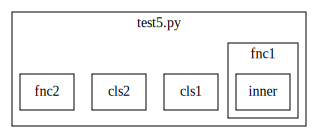

In [124]:
test